In [1]:
mv /Users/spangher/Downloads/K_100_iter_0_SFR_V3_10000_10280.json ../data/results/

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tqdm.auto import tqdm
import numpy as np 
import json
import pandas as pd 
y_pred_df = (
    pd.DataFrame(json.load(open('../data/results/K_100_iter_0_SFR_V3_10000_10280.json')))
)

In [67]:
disc_ordering = [
    'Analysis',
    'Anecdotes, Examples and Illustration',
    'Background Information',
    'Broadening Perspective',
    'Confirmation and Witness',
    'Counterpoint',
    'Data Resource',
    'Expert',
    'Main Actor',
    'Subject'
]

In [204]:
source_oracle_label_df = pd.read_csv('../data/v3_sources/oracle_labels.csv', index_col=0)
gold_truth_df = pd.DataFrame(json.load(open('../data/v3_sources/v3_combined_ALL_with_oracle.json')))
source_ground_truth_df = pd.DataFrame(gold_truth_df.explode('truth')['truth'].tolist())
y_pred_df_merged = y_pred_df.merge(gold_truth_df[['url', 'truth']])

In [256]:
cluster_center_df = pd.read_csv('../data/v3_clusters/cluster_centers.csv', index_col=0)

In [258]:
cluster_assignment_df = pd.read_csv('../data/v3_clusters/data_cluster_assignment.csv', index_col=0)

In [268]:
cluster_distributions_df = (
    (cluster_assignment_df.merge(cluster_center_df, right_index=True, left_on='cluster_pred_1').set_index('url')[disc_ordering] + 
     cluster_assignment_df.merge(cluster_center_df, right_index=True, left_on='cluster_pred_2').set_index('url')[disc_ordering] + 
     cluster_assignment_df.merge(cluster_center_df, right_index=True, left_on='cluster_pred_3').set_index('url')[disc_ordering]
    ).pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

In [269]:
row

url              www.wsj.com/articles/tech-firms-say-china-tari...
initial_story    How will the Trump administration's proposed t...
queries          [How will the Trump administration's proposed ...
dr_sources       [{'id': 'www.businessinsider.com/broadcom-ca-m...
truth            [{'url': 'www.wsj.com/articles/tech-firms-say-...
pred_num                                                        12
Name: 278, dtype: object

In [272]:
ks = [1, 4, 5, 6, 7, 8, 10, 12, 15, 20, 30, 40]

all_mean_prec_recall = []
for k in ks:
    ## vanilla
    all_prec_recall = []
    for _, row in tqdm(y_pred_df_merged.iterrows(), total=len(y_pred_df_merged)):
        y_pred_row = pd.DataFrame(row['dr_sources'])
        y_true_with_discourse = pd.DataFrame(row['truth'])
        prec_recall = (
            y_pred_row 
             .merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
             .sort_values('score', ascending=False).iloc[:k]
             [['url', 'Name']]
             .assign(y_pred=1)
             .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), how='outer')
             .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
             .pipe(lambda df: {
                 'precision': df['num_correct'].sum() / df['y_pred'].sum(),
                 'recall': df['num_correct'].sum() / df['y_true'].sum(),
             })
        )
        all_prec_recall.append(prec_recall)
        
    mean_prec_rec = (
        pd.DataFrame(all_prec_recall)
        .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
        .fillna(0)
        .mean()
        .to_dict()
    )
    mean_prec_rec['k'] = k
    mean_prec_rec['trial'] = 'vanilla rank'
    all_mean_prec_recall.append(mean_prec_rec)


    ## cluster distribution
    all_prec_recall = []
    for _, row in tqdm(y_pred_df_merged.iterrows(), total=len(y_pred_df_merged)):
        y_pred_row = pd.DataFrame(row['dr_sources'])
        y_pred_with_discourse = y_pred_row.merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
        y_true_with_discourse = pd.DataFrame(row['truth'])
    
        true_discourse_dist = cluster_distributions_df.loc[row['url']]
        discourse_cats_to_sample = (
            pd.DataFrame(np.random.multinomial(k, true_discourse_dist), index=disc_ordering, columns=['top_per_discourse'])
        )
        
        y_pred_at_k = (
            y_pred_with_discourse
                 .merge(discourse_cats_to_sample, left_on='llama_label', right_index=True)
                 .groupby('llama_label')
                 .apply(lambda df: df.sort_values('score', ascending=False).iloc[:df['top_per_discourse'].iloc[0]])
        )
        
        prec_recall = (
            y_pred_at_k[['url', 'Name']]
                 .assign(y_pred=1)
                 .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), on=['url', 'Name'], how='outer')
                 .fillna(0)
                 .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
                 .pipe(lambda df: {
                     'precision': df['num_correct'].sum() / df['y_pred'].sum(),
                     'recall': df['num_correct'].sum() / df['y_true'].sum(),
                 })
        )

        all_prec_recall.append(prec_recall)
        
    mean_prec_rec = (
        pd.DataFrame(all_prec_recall)
        .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
        .fillna(0)
        .mean()
        .to_dict()
    )
    mean_prec_rec['k'] = k
    mean_prec_rec['trial'] = 'clustered rank'
    all_mean_prec_recall.append(mean_prec_rec)

    ## with oracle
    all_prec_recall = []
    for _, row in tqdm(y_pred_df_merged.iterrows(), total=len(y_pred_df_merged)):
        y_pred_row = pd.DataFrame(row['dr_sources'])
        y_pred_with_discourse = y_pred_row.merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
        y_true_with_discourse = pd.DataFrame(row['truth'])
    
        true_discourse_dist = (
            y_true_with_discourse['llama_label']
                 .value_counts()
                 .reindex(disc_ordering)
                 .fillna(0)
                 .pipe(lambda s: s/s.sum())
        )
        discourse_cats_to_sample = (
            pd.DataFrame(np.random.multinomial(k, true_discourse_dist), index=disc_ordering, columns=['top_per_discourse'])
        )
        
        y_pred_at_k = (
            y_pred_with_discourse
                 .merge(discourse_cats_to_sample, left_on='llama_label', right_index=True)
                 .groupby('llama_label')
                 .apply(lambda df: df.sort_values('score', ascending=False).iloc[:df['top_per_discourse'].iloc[0]])
        )
        
        prec_recall = (
            y_pred_at_k[['url', 'Name']]
                 .assign(y_pred=1)
                 .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), on=['url', 'Name'], how='outer')
                 .fillna(0)
                 .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
                 .pipe(lambda df: {
                     'precision': df['num_correct'].sum() / df['y_pred'].sum(),
                     'recall': df['num_correct'].sum() / df['y_true'].sum(),
                 })
        )

        all_prec_recall.append(prec_recall)
        
    mean_prec_rec = (
        pd.DataFrame(all_prec_recall)
        .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
        .fillna(0)
        .mean()
        .to_dict()
    )
    mean_prec_rec['k'] = k
    mean_prec_rec['trial'] = 'oracle rank'
    all_mean_prec_recall.append(mean_prec_rec)

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:63: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:63: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:63: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:63: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:63: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred

  0%|          | 0/279 [00:00<?, ?it/s]

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:113: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:113: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_56027/790759152.py:113: RuntimeWarning: invalid value encountered in scalar divide
  'precision': df['num_correct'].sum() / df['y_pred'].sum(),


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

<Axes: xlabel='k', ylabel='f1_score'>

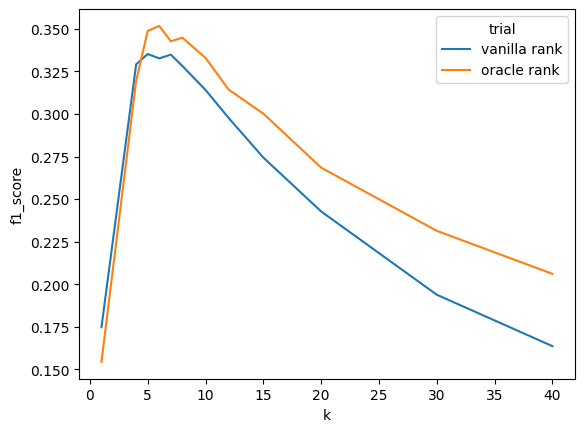

In [203]:
import seaborn as sns 
sns.lineplot(
    data =pd.DataFrame(all_mean_prec_recall).reset_index(),
    x='k',
    y='f1_score',
    hue='trial'
)

# Use Poisson Random Variable

In [208]:
predicted_number = pd.read_json('../data/results/poisson_regression.jsonl', lines=True)

In [214]:
y_pred_df_merged_with_num = y_pred_df_merged.merge(predicted_number[['url', 'y_pred']].rename(columns={'y_pred': 'pred_num'}))

In [218]:
# vanilla
pred_k__mean_prec_recall = []
all_prec_recall = []
for _, row in tqdm(y_pred_df_merged_with_num.iterrows(), total=len(y_pred_df_merged_with_num)):
    k = row['pred_num']
    y_pred_row = pd.DataFrame(row['dr_sources'])
    y_true_with_discourse = pd.DataFrame(row['truth'])
    prec_recall = (
        y_pred_row 
         .merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
         .sort_values('score', ascending=False).iloc[:k]
         [['url', 'Name']]
         .assign(y_pred=1)
         .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), how='outer')
         .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
         .pipe(lambda df: {
             'precision': df['num_correct'].sum() / df['y_pred'].sum(),
             'recall': df['num_correct'].sum() / df['y_true'].sum(),
         })
    )
    all_prec_recall.append(prec_recall)
    
mean_prec_rec = (
    pd.DataFrame(all_prec_recall)
    .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
    .fillna(0)
    .mean()
    .to_dict()
)
mean_prec_rec['k'] = 'pred'
mean_prec_rec['trial'] = 'vanilla rank'
pred_k__mean_prec_recall.append(mean_prec_rec)

## with oracle
all_prec_recall = []
for _, row in tqdm(y_pred_df_merged_with_num.iterrows(), total=len(y_pred_df_merged_with_num)):
    k = row['pred_num']
    y_pred_row = pd.DataFrame(row['dr_sources'])
    y_pred_with_discourse = y_pred_row.merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
    y_true_with_discourse = pd.DataFrame(row['truth'])

    true_discourse_dist = (
        y_true_with_discourse['llama_label']
             .value_counts()
             .reindex(disc_ordering)
             .fillna(0)
             .pipe(lambda s: s/s.sum())
    )
    discourse_cats_to_sample = (
        pd.DataFrame(np.random.multinomial(k, true_discourse_dist), index=disc_ordering, columns=['top_per_discourse'])
    )
    
    y_pred_at_k = (
        y_pred_with_discourse
             .merge(discourse_cats_to_sample, left_on='llama_label', right_index=True)
             .groupby('llama_label')
             .apply(lambda df: df.sort_values('score', ascending=False).iloc[:df['top_per_discourse'].iloc[0]])
    )
    
    prec_recall = (
        y_pred_at_k[['url', 'Name']]
             .assign(y_pred=1)
             .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), on=['url', 'Name'], how='outer')
             .fillna(0)
             .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
             .pipe(lambda df: {
                 'precision': df['num_correct'].sum() / df['y_pred'].sum(),
                 'recall': df['num_correct'].sum() / df['y_true'].sum(),
             })
    )

    all_prec_recall.append(prec_recall)
    
mean_prec_rec = (
    pd.DataFrame(all_prec_recall)
    .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
    .fillna(0)
    .mean()
    .to_dict()
)
mean_prec_rec['k'] = 'pred'
mean_prec_rec['trial'] = 'oracle rank'
pred_k__mean_prec_recall.append(mean_prec_rec)

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

In [223]:
pd.DataFrame(pred_k__mean_prec_recall)

,precision,recall,f1_score,k,trial
0,0.246512,0.445974,0.300844,pred,vanilla rank
1,0.263850,0.474635,0.322231,pred,oracle rank


# Try Ground-Truth Rank

In [245]:
# vanilla
pred_k__mean_prec_recall = []
all_prec_recall = []
for _, row in tqdm(y_pred_df_merged_with_num.iterrows(), total=len(y_pred_df_merged_with_num)):
    k = len(row['truth'])
    y_pred_row = pd.DataFrame(row['dr_sources'])
    y_true_with_discourse = pd.DataFrame(row['truth'])
    prec_recall = (
        y_pred_row 
         .merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
         .sort_values('score', ascending=False).iloc[:k]
         [['url', 'Name']]
         .assign(y_pred=1)
         .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), how='outer')
         .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
         .pipe(lambda df: {
             'precision': df['num_correct'].sum() / df['y_pred'].sum(),
             'recall': df['num_correct'].sum() / df['y_true'].sum(),
         })
    )
    all_prec_recall.append(prec_recall)
    
mean_prec_rec = (
    pd.DataFrame(all_prec_recall)
    .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
    .fillna(0)
    .mean()
    .to_dict()
)
mean_prec_rec['k'] = 'ground_truth'
mean_prec_rec['trial'] = 'vanilla rank'
pred_k__mean_prec_recall.append(mean_prec_rec)

## with oracle
all_prec_recall = []
for _, row in tqdm(y_pred_df_merged_with_num.iterrows(), total=len(y_pred_df_merged_with_num)):
    k = len(row['truth'])
    y_pred_row = pd.DataFrame(row['dr_sources'])
    y_pred_with_discourse = y_pred_row.merge(source_ground_truth_df, left_on='text', right_on='Text_embed')
    y_true_with_discourse = pd.DataFrame(row['truth'])

    discourse_cats_to_sample = (
        y_true_with_discourse['llama_label']
             .value_counts()
             # .reindex(disc_ordering)
             # .fillna(0)
             .to_frame('top_per_discourse')
             # .pipe(lambda s: s/s.sum())
    )
    # discourse_cats_to_sample = (
        # pd.DataFrame(np.random.multinomial(k, true_discourse_dist), index=disc_ordering, columns=['top_per_discourse'])
    # )
    
    y_pred_at_k = (
        y_pred_with_discourse
             .merge(discourse_cats_to_sample, left_on='llama_label', right_index=True)
             .groupby('llama_label')
             .apply(lambda df: df.sort_values('score', ascending=False).iloc[:df['top_per_discourse'].iloc[0]])
    )
    
    prec_recall = (
        y_pred_at_k[['url', 'Name']]
             .assign(y_pred=1)
             .merge(y_true_with_discourse[['url', 'Name']].assign(y_true=1), on=['url', 'Name'], how='outer')
             .fillna(0)
             .assign(num_correct=lambda df: (df['y_pred'] + df['y_true']) > 1)
             .pipe(lambda df: {
                 'precision': df['num_correct'].sum() / df['y_pred'].sum(),
                 'recall': df['num_correct'].sum() / df['y_true'].sum(),
             })
    )

    all_prec_recall.append(prec_recall)
    
mean_prec_rec = (
    pd.DataFrame(all_prec_recall)
    .assign(f1_score=lambda df:  2 * (df['precision'] * df['recall']) / (df['precision'] + df['recall']))
    .fillna(0)
    .mean()
    .to_dict()
)
mean_prec_rec['k'] = 'ground_truth'
mean_prec_rec['trial'] = 'oracle rank'
pred_k__mean_prec_recall.append(mean_prec_rec)

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

In [246]:
pd.DataFrame(pred_k__mean_prec_recall)

,precision,recall,f1_score,k,trial
0,0.366292,0.366292,0.366292,ground_truth,vanilla rank
1,0.431328,0.429184,0.430147,ground_truth,oracle rank
